# 1. Predicting Gender by First Name Using Character-level Machine Learning

*Please cite:*

Rego, R. C., Silva, V. M. & Fernandes, V. M. (2021). **Predicting Gender by First Name Using Character-level Machine Learning**. arXiv preprint arXiv:2106.10156 v2.




## 1.1 Necessary libraries

In [22]:
import pandas as pd                       
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow import keras
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, GRU, SimpleRNN, LSTM, Bidirectional, Activation, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

## 1.2 Download the dataset

In [2]:
import requests
url = "https://data.brasil.io/dataset/genero-nomes/nomes.csv.gz"
filename = url.split("/")[-1]
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

df = pd.read_csv('nomes.csv.gz') 
df.head()

,alternative_names,classification,first_name,frequency_female,frequency_male,frequency_total,frequency_group,group_name,ratio
0,AILINE|ALEINE|ALIINE|ALINE|ALINER|ALINHE|ALINN...,F,AALINE,66.0,NaN,66,530550,ALINE,1.0
1,ARAAO|ARAO,M,AARAO,NaN,281.0,281,3526,ARAO,1.0
2,AHARON|AROM|ARON|ARYON|HARON,M,AARON,NaN,676.0,676,3442,ARON,1.0
3,ADA|ADAH|ADAR|ADHA|HADA,F,ABA,82.0,NaN,82,5583,ADA,1.0
4,NaN,M,ABADE,NaN,57.0,57,57,ABADE,1.0


### 1.2.1 Preparing the data 

In [3]:
y = df['classification'].astype("category").cat.codes.values    # y labels into numbers 0 is F and 1 is M
names = df['first_name'].apply(lambda x: x.lower())             # input names

In [4]:
print("M : " + str(sum(y==1)))
print("F : " + str(sum(y==0)))
print(len(y))

M : 45537
F : 55250
100787


## 1.3 Encoding Words

Neural networks can only learn to find patterns in numerical data, so it is necessary to convert our data into numeric values with word encoding or tokenization. 

In [5]:
#word encoding
maxlen = 20                                               # max lenght of a name

'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in names]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)

char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary
''' The dictionary maps each letter of vocabulary to a number '''

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

'''This is called one-hot-encoder and is based on the following papers: 
https://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names
https://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...
 '''

'This is called one-hot-encoder and is based on the following papers: \nhttps://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names\nhttps://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...\n '

In [6]:
x = prepare_encod_names(names.values)   # Now the names are encod as a vector of numbers 

## 1.4 Split the data into test and train

In [25]:
# train, val, test set will be 60%, 20%, 20% of the dataset respectively
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=28)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_val = np.asarray(x_val)
y_val = np.asarray(y_val)

In [29]:
# Callbacks
callbacks = [EarlyStopping(monitor='accuracy', mode="max", patience=5)]

## 1.5 Building the CNN Model

In [36]:
CNNmodel = keras.Sequential()
CNNmodel.add(Conv1D(256, 3, activation='relu', kernel_initializer='he_uniform', input_shape=(20, 28)))
CNNmodel.add(Conv1D(256, 3, activation='relu'))
CNNmodel.add(Flatten())
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
CNNmodel.add(Dropout(0.2))
CNNmodel.add(Dense(1, activation='sigmoid', kernel_initializer='he_uniform'))

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

CNNmodel.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

CNNhistory = CNNmodel.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=256, callbacks=callbacks)
CNNscores = CNNmodel.evaluate(x_test, y_test)  

Epoch 1/20
252/252 [==============================] - 65s 257ms/step - loss: 0.2516 - accuracy: 0.8911 - val_loss: 0.1741 - val_accuracy: 0.9358
Epoch 2/20
252/252 [==============================] - 65s 258ms/step - loss: 0.1619 - accuracy: 0.9371 - val_loss: 0.1538 - val_accuracy: 0.9410
Epoch 3/20
252/252 [==============================] - 65s 256ms/step - loss: 0.1398 - accuracy: 0.9463 - val_loss: 0.1441 - val_accuracy: 0.9440
Epoch 4/20
252/252 [==============================] - 64s 254ms/step - loss: 0.1274 - accuracy: 0.9525 - val_loss: 0.1489 - val_accuracy: 0.9426
Epoch 5/20
252/252 [==============================] - 64s 255ms/step - loss: 0.1156 - accuracy: 0.9560 - val_loss: 0.1274 - val_accuracy: 0.9511
Epoch 6/20
252/252 [==============================] - 64s 256ms/step - loss: 0.1059 - accuracy: 0.9603 - val_loss: 0.1227 - val_accuracy: 0.9527
Epoch 7/20
252/252 [==============================] - 65s 256ms/step - loss: 0.0974 - accuracy: 0.9630 - val_loss: 0.1202 - val_ac

NameError: ignored

## 1.6 Figures

<Figure size 432x288 with 0 Axes>

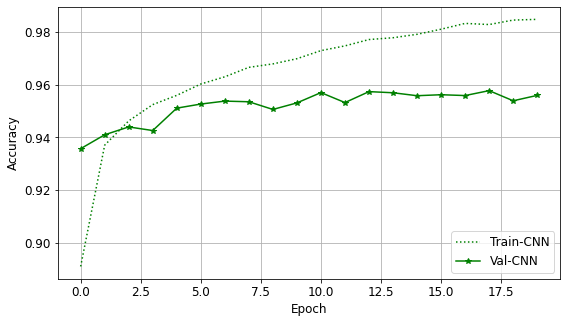

In [37]:
plt.figure(1)
plt.figure(figsize=(9,5))
plt.rcParams.update({'font.size': 12})
# summarize for accuracy
plt.plot(CNNhistory.history['accuracy'], 'g:')
plt.plot(CNNhistory.history['val_accuracy'], 'g-*')
#plt.xscale('log')
plt.grid('True')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.ylim(0.8, 0.99)
#plt.xlim(0,25)
plt.legend(['Train-CNN', 'Val-CNN'], loc='lower right')
#plt.gcf().savefig('accuracy.eps', format='eps', dpi=600)     # save the figure

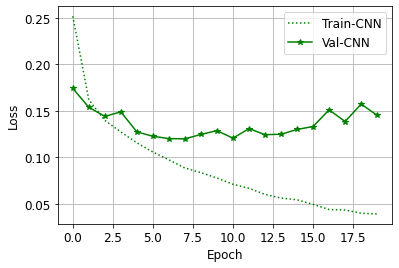

In [38]:
plt.figure(2)
# summarize for loss
plt.plot(CNNhistory.history['loss'], 'g:')
plt.plot(CNNhistory.history['val_loss'], 'g-*')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train-CNN', 'Val-CNN'], loc='upper right')
#plt.yscale('log')
#plt.xscale('log')
plt.grid('True')
#plt.xlim(0,32)
#plt.gcf().savefig('loss.eps', format='eps', dpi=600)     # save the figure

## 1.7 Statistics

In [39]:
y_predCNN =(CNNmodel.predict(x_test) > 0.5).astype("int32")
# Finding precision and recall
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_test, y_predCNN))
print(recall_score(y_test, y_predCNN))


0.9517173268956436
0.9526581722319859


## 1.8 Testing 

In [40]:
testename = prepare_encod_names({"cibely"})   # Now the names are encod as a vector of numbers with weight
resu=(CNNmodel.predict(testename) > 0.5).astype("int32")
if int(resu)==1:
  print('M')
else:
  print('F')

F
